In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from distfit import distfit
from scipy import stats
from scipy.special import gamma
import pickle
from SkillingsMack import cMackSkil
from collections import Counter
import random
from rliable import library as rly
from rliable import metrics

In [2]:

#@title Record scores on Atari games
record_scores = False

ALL_HUMAN_RECORD = {
  'Alien': 251916.0,
  'Amidar': 104159.0,
  'Assault': 8647.0,
  'Asterix': 1000000.0,
  'Asteroids': 10506650.0,
  'Atlantis': 10604840.0,
  'BankHeist': 82058.0,
  'BattleZone': 801000.0,
  'BeamRider': 999999.0,
  'Berzerk': 1057940.0,
  'Bowling': 300.0,
  'Boxing': 100.0,
  'Breakout': 864.0,
  'Centipede': 1301709.0,
  'ChopperCommand': 999999.0,
  'CrazyClimber': 219900.0,
  'DemonAttack': 1556345.0,
  'DoubleDunk': 22.0,
  'Enduro': 9500.0,
  'FishingDerby': 71.0,
  'Freeway': 38.0,
  'Frostbite': 454830.0,
  'Gopher': 355040.0,
  'Gravitar': 162850.0,
  'Hero': 1000000.0,
  'IceHockey': 36.0,
  'Jamesbond': 45550.0,
  'Kangaroo': 1424600.0,
  'Krull': 104100.0,
  'KungFuMaster': 1000000.0,
  'MontezumaRevenge': 1219200.0,
  'MsPacman': 290090.0,
  'NameThisGame': 25220.0,
  'Phoenix': 4014440.0,
  'Pitfall': 114000.0,
  'Pong': 21.0,
  'PrivateEye': 101800.0,
  'Qbert': 2400000.0,
  'Riverraid': 1000000.0,
  'RoadRunner': 2038100.0,
  'Robotank': 76.0,
  'Seaquest': 999999.0,
  'Skiing': -3272.0,
  'Solaris': 111420.0,
  'SpaceInvaders': 621535.0,
  'StarGunner': 77400.0,
  'Tennis': 21.0,
  'TimePilot': 65300.0,
  'Tutankham': 5384.0,
  'UpNDown': 82840.0,
  'Venture': 38900.0,
  'VideoPinball': 89218328.0,
  'WizardOfWor': 395300.0,
  'YarsRevenge': 15000105.0,
  'Zaxxon': 83700.0,
  'AirRaid': 23050.0,
  'Carnival': 2541440.0,
  'ElevatorAction': 156550.0,
  'JourneyEscape': -4317804.0,
  'Pooyan': 13025.0
}
RANDOM_SCORES = {
 'Alien': 227.8,
 'Amidar': 5.8,
 'Assault': 222.4,
 'Asterix': 210.0,
 'BankHeist': 14.2,
 'BattleZone': 2360.0,
 'Boxing': 0.1,
 'Breakout': 1.7,
 'ChopperCommand': 811.0,
 'CrazyClimber': 10780.5,
 'DemonAttack': 152.1,
 'Freeway': 0.0,
 'Frostbite': 65.2,
 'Gopher': 257.6,
 'Hero': 1027.0,
 'Jamesbond': 29.0,
 'Kangaroo': 52.0,
 'Krull': 1598.0,
 'KungFuMaster': 258.5,
 'MsPacman': 307.3,
 'Pong': -20.7,
 'PrivateEye': 24.9,
 'Qbert': 163.9,
 'RoadRunner': 11.5,
 'Seaquest': 68.4,
 'UpNDown': 533.4
}

HUMAN_SCORES = {
 'Alien': 7127.7,
 'Amidar': 1719.5,
 'Assault': 742.0,
 'Asterix': 8503.3,
 'BankHeist': 753.1,
 'BattleZone': 37187.5,
 'Boxing': 12.1,
 'Breakout': 30.5,
 'ChopperCommand': 7387.8,
 'CrazyClimber': 35829.4,
 'DemonAttack': 1971.0,
 'Freeway': 29.6,
 'Frostbite': 4334.7,
 'Gopher': 2412.5,
 'Hero': 30826.4,
 'Jamesbond': 302.8,
 'Kangaroo': 3035.0,
 'Krull': 2665.5,
 'KungFuMaster': 22736.3,
 'MsPacman': 6951.6,
 'Pong': 14.6,
 'PrivateEye': 69571.3,
 'Qbert': 13455.0,
 'RoadRunner': 7845.0,
 'Seaquest': 42054.7,
 'UpNDown': 11693.2
}

NORM_BASELINE = ALL_HUMAN_RECORD if record_scores else HUMAN_SCORES 

def score_normalization(scores, min_scores, max_scores):
  # min should be random scores, max should be human scores.
  norm_scores = np.divide(np.subtract(scores, min_scores), max_scores - min_scores)
  return norm_scores

# False positive rate

In [3]:
STATSDISTRI = {
    "norm": stats.norm,
    "t": stats.t,
    "dweibull": stats.dweibull,
    "expon": stats.expon,
    "gamma": stats.gamma,
    "genextreme": stats.genextreme,
    "beta": stats.beta,
    "pareto": stats.pareto,
    "lognorm": stats.lognorm,
    "loggamma": stats.loggamma
}

def rvs_enforce(distr_name:str = "norm", mean :float = 0, var: float =1,  size: int = 10)-> int:
    match distr_name:
        case "norm":
            PARAMETERS = {      "norm":         {"loc": [mean], "scale": [np.sqrt(var)]}}
        case "t":
            df_t = size-1
            # PARAMETERS = {      "t":            {"loc": [mean], "scale": [np.sqrt(var*(df_t-2)/df_t)], "df": [df_t]}} # GIUSTO
            PARAMETERS = {      "t":            {"loc": [mean], "scale": [np.sqrt(var*(df_t-1)/df_t)], "df": [df_t]}}  # TODO formula sbagliata
        case "dweibull":
            c = random.choice([1, 2, 3])
            PARAMETERS = {      "dweibull":     {"loc": [mean], "scale": [np.sqrt(var/gamma(1+2/c))], "c": [c]}}
        case "expon":
            PARAMETERS = {      "expon":        {"loc": [mean - np.sqrt(var)], "scale": [np.sqrt(var)]}}
        case "gamma":
            a = 1.5
            PARAMETERS = {      "gamma":        {"loc": [mean-a*np.sqrt(var/a)], "scale": [np.sqrt(var/a)], "a": [a]}}
        case "beta":
            a = 1
            b = 2
            scale = np.sqrt(var)/np.sqrt(a*b/((a+b+1)*(a+b)**2))
            PARAMETERS = {      "beta":         {"loc": [mean -a/(a + b)*scale], "scale": [scale], "a": [a], "b": [b]}}
        case "pareto":
            b = 1
            scale = np.sqrt(var*((b-1)**2*(b-2))/b)
            PARAMETERS = {      "pareto":       {"loc": [mean - b/(b-1)*scale], "scale": [scale], "b": [b]}}
        case "lognorm":
            s = 0.5
            scale =np.sqrt(var/((np.exp(s**2)-1)*np.exp(s**2)))
            PARAMETERS = {      "lognorm":      {"loc": [mean-np.exp(s**2/2)*scale], "scale": [scale], "s": [s]}}
        case "loggamma":
            PARAMETERS = {      "loggamma":     {"loc": [0], "scale": [1], "c": [1.5]}}
            raise ValueError("loggamma not implemented")
        case "genextreme":
            PARAMETERS = {      "genextreme":   {"loc": [0], "scale": [1], "c": [0]}}
            raise ValueError("genextreme not implemented")
        case _ :
            raise ValueError("Unknown distribution")
    
    arguments = dict()
    for attribute in PARAMETERS[distr_name].keys():
        attribute_value = random.choice(PARAMETERS[distr_name][attribute]) # Non piu necessario fare il random choice.
        arguments.update({attribute: attribute_value})
        # setattr(distribution, attribute, attribute_value)
        # print(distr_name,  attribute, attribute_value)

    random_variable = STATSDISTRI[distr_name](**arguments)
    # rv_mean = random_variable.mean()
    # rv_var = random_variable.var()

    # sample = (random_variable.rvs(size = size) - rv_mean)/np.sqrt(rv_var)* np.sqrt(var) + mean
    
    # TODO random seed initializing
    return random_variable.rvs(size = size)

In [4]:
IQM = lambda x: metrics.aggregate_iqm(x) # Interquartile Mean
OG = lambda x: metrics.aggregate_optimality_gap(x, 1.0) # Optimality Gap
MEAN = lambda x: metrics.aggregate_mean(x)
MEDIAN = lambda x: metrics.aggregate_median(x)

def strat_bootstrap(observ, C, reps=50000):
    N, KC = np.shape(observ)
    K = int(KC/C)
    score_dict = dict()
    for k in range(K):
         score_dict.update({k: np.transpose(observ[:, k*C:k*C+C])})
    
    aggregate_func = lambda x: np.array([IQM(x), MEDIAN(x)])
    aggregate_scores, aggregate_interval_estimates = rly.get_interval_estimates(
        score_dict, aggregate_func, reps=reps)
    return aggregate_scores, aggregate_interval_estimates

def intervals_overlap(aggregate_interval_estimates):
    # Assumes that IQM is the first function of aggregate_func!
    upbound_p0 = aggregate_interval_estimates[0][1, 0]
    lowbound_p0 = aggregate_interval_estimates[0][0, 0]
    upbound_p1 = aggregate_interval_estimates[1][1, 0]
    lowbound_p1 = aggregate_interval_estimates[1][0, 0]

    return min(upbound_p0, upbound_p1) - max(lowbound_p0, lowbound_p1)

def intervals_overlap_inference(aggregate_interval_estimates, eps):
    # Assumes that IQM is the first function of aggregate_func!
    upbound_p0 = aggregate_interval_estimates[0][1, 0]
    lowbound_p0 = aggregate_interval_estimates[0][0, 0]
    p0_mean = np.mean([upbound_p0, lowbound_p0])
    upbound_p0 = (upbound_p0 - p0_mean)*eps + p0_mean
    lowbound_p0 = p0_mean - (p0_mean - lowbound_p0)*eps

    upbound_p1 = aggregate_interval_estimates[1][1, 0]
    lowbound_p1 = aggregate_interval_estimates[1][0, 0]
    p1_mean = np.mean([upbound_p1, lowbound_p1])
    upbound_p1 = (upbound_p1 - p1_mean)*eps + p1_mean
    lowbound_p1 = p1_mean - (p1_mean - lowbound_p1)*eps

    return min(upbound_p0, upbound_p1) - max(lowbound_p0, lowbound_p1)
    

In [5]:
def run_simulation(nominal_alpha:float= 0.05, K:int = 2, N:int=5, Nsim:int=100, TASK_MEAN:list=list([[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]), TASK_VAR:list=list([[1, 1, 1, 1, 1], [1, 1, 1, 1, 1]]),  TASK_DISTR:list=list([["norm", "norm", "norm", "norm","norm"], ["norm", "norm", "norm", "norm","norm"]]), SB_reps:int = 100 ):
    # K Number of treatments (i.e. number of algorithms)
    # N Number of blocks (i.e. number of games)
    # Nsim Number of simulation points for computing the effective alpha
    # task_mean list of means for each task. Assumes the two policies have the same distribution.
    # task_var list of variances for each task. Assumes the two policies have the same distribution.
    # task_distr list of distribution names for each task. Assumes the two policies have the same distribution.

    if np.shape(np.array(TASK_MEAN)) != (K, N):
        raise ValueError("Wrong shape length")

    if np.shape(np.array(TASK_MEAN)) != np.shape(np.array(TASK_VAR)) and np.shape(np.array(TASK_MEAN)) != np.shape(np.array(TASK_DISTR)):
        raise ValueError("The shape of TASK_MEAN, TASK_VAR and TASK_DISTR do not correspond")

    
    MSv = np.zeros(Nsim)
    p_vals_t = np.zeros(Nsim)
    p_vals_welch = np.zeros(Nsim)
    p_vals_welch_trim = np.zeros(Nsim)
    SBv = np.zeros(Nsim)
    SBov = np.zeros(Nsim)

    Cs = list([2, 3, 5, 10, 15, 20, 50]) 

    fpos_MS = np.zeros(len(Cs))
    fpos_t = np.zeros(len(Cs))
    fpos_welch = np.zeros(len(Cs))
    fpos_welch_trim = np.zeros(len(Cs))
    fpos_SB = np.zeros(len(Cs))
    fpos_SBo = np.zeros(len(Cs))

    for g in range(len(Cs)):
        C = Cs[g]           # number of datapoints for each treatment/block combination
        num_obs = K * N * C
        critical_value= cMackSkil(nominal_alpha, K, N, C, method="Asymptotic")['p_val']
        for f in range(Nsim): # Repeat the experiment Nsim times.
            observ = np.zeros((N, K*C))
            for i in range(N): # Loop over the number of tasks
                for j in range(K): # Loop over the different policies
                    task_mean = TASK_MEAN[j][i]
                    task_var = TASK_VAR[j][i]
                    task_distr = TASK_DISTR[j][i]
                    match j:
                        case 0: # Reference treatment
                            ref_sample = rvs_enforce(distr_name=task_distr, mean=task_mean, var=task_var, size=C)
                            observ[i, j*C:j*C+C] = ref_sample
                        case 1: # Alternative treatment
                            altern_sample = rvs_enforce(distr_name=task_distr, mean=task_mean, var= task_var, size=C)
                            observ[i, j*C:j*C+C] = altern_sample

            # Compute the Mack-Skillings test
            ranks = stats.rankdata(observ, axis=1) # rank 1 corrisponde al valore piu' piccolo
            ranks = -np.add(ranks, -np.max(ranks+1)) # rank 1 adesso é il migliore
            avg_rank = np.zeros((N, K))
            for i in range(N):
                for j in range(K):
                    avg_rank[i, j] = np.mean(ranks[i, j*C: j*C+C])
            S = np.mean(avg_rank, axis=0)*N
            MS = 12/(K*(num_obs+N))*np.sum(np.power(S,2)) -3*(num_obs+N)
            # print(f'Computed statistic: {MS} {"greater" if MS>critical_value else "smaller"} than critical value {critical_value}')
            MSv[f] = MS

            # Compute 2-sample tests (t, welch yuen). Assuming we merge all the data from the different tasks together
            sample1 = np.reshape(observ[:, 0:C], -1)
            sample2 = np.reshape(observ[:, C:2*C], -1)
            _, p_vals_t[f] = stats.ttest_ind(sample1, sample2, equal_var=True, alternative='two-sided', trim=0)
            _, p_vals_welch[f] = stats.ttest_ind(sample1, sample2, equal_var=False, alternative='two-sided', trim=0)
            _, p_vals_welch_trim[f] = stats.ttest_ind(sample1, sample2, equal_var=False, alternative='two-sided', trim=0.1)

            # Stratified bootstrap
            # aggregate_interval_estimates fornisce l'upper and lower bound.
            aggregate_scores, aggregate_interval_estimates = strat_bootstrap(observ, C, reps=SB_reps)
            m1 = np.mean(sample1)
            m2 = np.mean(sample2)
            if m2>=m1:
                eps = (m2-m1+ (critical_value-MS))/(m2-m1+ aggregate_interval_estimates[0][1, 0]- aggregate_interval_estimates[1][0, 0])  # Uses MackSkilling. Assumes IQM is the first !!
            else:
                eps = (m1-m2+(critical_value-MS))/(m1-m2+ aggregate_interval_estimates[1][1, 0]- aggregate_interval_estimates[0][0, 0])  # Uses MackSkilling. Assumes IQM is the first !!
            # z = stats.norm.ppf((1-nominal_alpha/2))
            SBv[f] = intervals_overlap(aggregate_interval_estimates)
            SBov[f] = intervals_overlap_inference(aggregate_interval_estimates, eps)

        fpos_MS[g] = np.sum(MSv>critical_value)/Nsim
        fpos_t[g] = np.sum(p_vals_t<nominal_alpha)/Nsim
        fpos_welch[g] = np.sum(p_vals_welch<nominal_alpha)/Nsim
        fpos_welch_trim[g] = np.sum(p_vals_welch_trim<nominal_alpha)/Nsim
        fpos_SB[g] = np.sum(SBv<0)/Nsim
        fpos_SBo[g] = np.sum(SBov<0)/Nsim
        
    return fpos_MS, fpos_t, fpos_welch, fpos_welch_trim, fpos_SB, fpos_SBo
Cs = list([2, 3, 5, 10, 15, 20, 50]) 


In [6]:
# from rliable import plot_utils
# import seaborn as sns

# colors = sns.color_palette('colorblind')
# xlabels = ['policy0', 'policy1']
# color_idxs = [0, 3]
# ATARI_100K_COLOR_DICT = dict(zip(xlabels, [colors[idx] for idx in color_idxs]))


# fig, axes = plot_utils.plot_interval_estimates(
#     aggregate_scores, 
#     aggregate_interval_estimates,
#     metric_names = ['IQM', 'MEDIAN'],
#     algorithms=['0', '1'],
#     colors=ATARI_100K_COLOR_DICT,
#     xlabel_y_coordinate=-0.16,
#     xlabel='Human Normalized Score')
# plt.show()

In [7]:
N=2
K = 2
Nsim=5000
nominal_alpha = 0.05

Text(0.5, 0, 'Aggregated sample size')

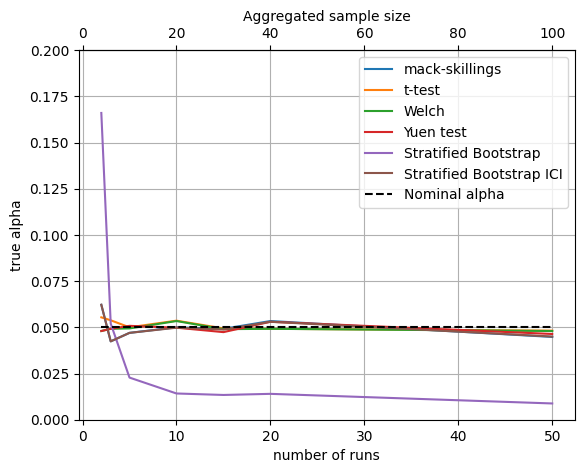

In [8]:
# Two policies and 5 tasks. We start with the most simple case, where all distributions are normal and have same mean and variance.


# fpos_MS, fpos_t, fpos_welch, fpos_welch_trim = run_simulation(nominal_alpha=0.05)
fpos_MS, fpos_t, fpos_welch, fpos_welch_trim, fpos_SB, fpos_SBo = run_simulation(nominal_alpha=nominal_alpha, N=N, K=K, Nsim = Nsim, TASK_MEAN=list([[0, 0], [0, 0]]), TASK_VAR=list([[1, 1], [1, 1]]),  TASK_DISTR=list([["norm", "norm"], ["norm", "norm"]]))
# fpos_MS, fpos_t, fpos_welch, fpos_welch_trim = run_simulation(nominal_alpha=0.05, N=1, TASK_MEAN=list([[0], [0]]), TASK_VAR=list([[1], [1]]),  TASK_DISTR=list([["norm"], ["norm"]]))

run_to_sample = lambda x : x *K
sample_to_run = lambda x : x /K

fig, ax = plt.subplots()
ax.plot(Cs, fpos_MS, label='mack-skillings')
ax.plot(Cs, fpos_t, label='t-test')
ax.plot(Cs, fpos_welch, label='Welch')
ax.plot(Cs, fpos_welch_trim, label='Yuen test')
ax.plot(Cs, fpos_SB, label='Stratified Bootstrap')
ax.plot(Cs, fpos_SBo, label='Stratified Bootstrap ICI')
ax.plot(Cs, nominal_alpha*np.ones(len(Cs)), 'k--', label='Nominal alpha')
ax.legend()
ax.grid()
ax.set_xlabel('number of runs')
ax.set_ylabel('true alpha')
ax.set_ylim([0, 0.2])
secax = ax.secondary_xaxis('top', functions=(run_to_sample, sample_to_run))
secax.set_xlabel('Aggregated sample size')

# TODO 5000 simulazioni almeno
# stratified bootstrap è troppo conservativo! Non rifiuta mai l'ipotesi nulla. --> potenza bassa del test
# L'alpha vero deve essere come quello imposto.
# TODO introdurre inference confidence interval 

Text(0.5, 0, 'Aggregated sample size')

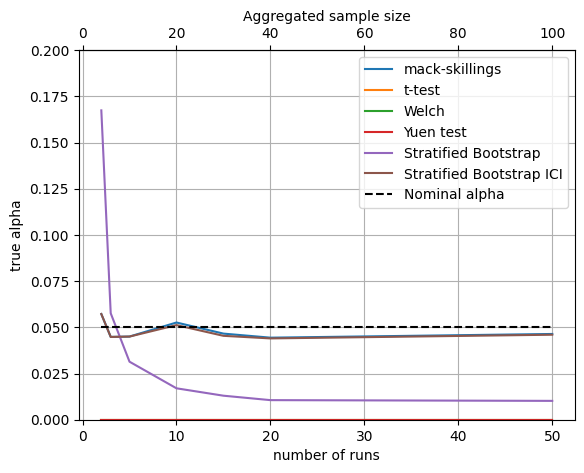

In [9]:
# Two policies and 2 tasks. All distributions have normal distribution but different tasks have different means

fpos_MS, fpos_t, fpos_welch, fpos_welch_trim, fpos_SB, fpos_SBo = run_simulation(nominal_alpha=nominal_alpha, N=N, K=K, Nsim = Nsim, TASK_MEAN=list([[0.001, 10], [0.001, 10]]), TASK_VAR=list([[1, 1], [1, 1]]),  TASK_DISTR=list([["norm", "norm"], ["norm", "norm"]]))
# fpos_MS, fpos_t, fpos_welch, fpos_welch_trim = run_simulation(nominal_alpha=0.05, TASK_MEAN=list([[0, -1, 0.001, 10, 100], [0, -1, 0.001, 10, 100]]))

run_to_sample = lambda x : x *K
sample_to_run = lambda x : x /K

fig, ax = plt.subplots()
ax.plot(Cs, fpos_MS, label='mack-skillings')
ax.plot(Cs, fpos_t, label='t-test')
ax.plot(Cs, fpos_welch, label='Welch')
ax.plot(Cs, fpos_welch_trim, label='Yuen test')
ax.plot(Cs, fpos_SB, label='Stratified Bootstrap')
ax.plot(Cs, fpos_SBo, label='Stratified Bootstrap ICI')
ax.plot(Cs, nominal_alpha*np.ones(len(Cs)), 'k--', label='Nominal alpha')
ax.legend()
ax.grid()
ax.set_xlabel('number of runs')
ax.set_ylabel('true alpha')
ax.set_ylim([0, 0.2])
secax = ax.secondary_xaxis('top', functions=(run_to_sample, sample_to_run))
secax.set_xlabel('Aggregated sample size')


Text(0.5, 0, 'Aggregated sample size')

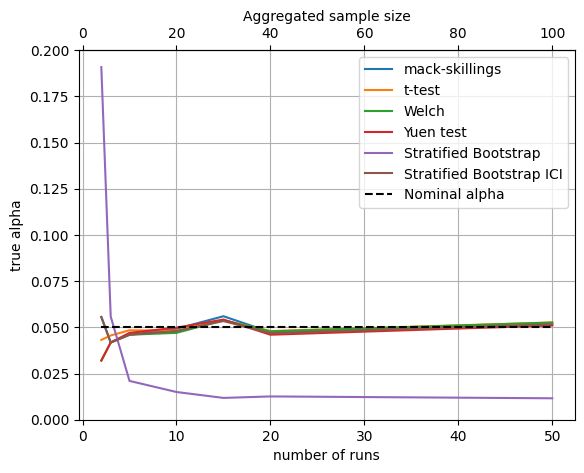

In [10]:
# Two policies and 2 tasks. All distributions have normal distribution but different tasks have different variance

fpos_MS, fpos_t, fpos_welch, fpos_welch_trim, fpos_SB, fpos_SBo = run_simulation(nominal_alpha=nominal_alpha, N=N, K=K, Nsim = Nsim, TASK_MEAN=list([[0, 0], [0, 0]]), TASK_VAR=list([[1, 4], [1, 4]]),  TASK_DISTR=list([["norm", "norm"], ["norm", "norm"]]))
# fpos_MS, fpos_t, fpos_welch, fpos_welch_trim = run_simulation(nominal_alpha=0.05, TASK_MEAN=list([[0, -1, 0.001, 10, 100], [0, -1, 0.001, 10, 100]]))

run_to_sample = lambda x : x *K
sample_to_run = lambda x : x /K

fig, ax = plt.subplots()
ax.plot(Cs, fpos_MS, label='mack-skillings')
ax.plot(Cs, fpos_t, label='t-test')
ax.plot(Cs, fpos_welch, label='Welch')
ax.plot(Cs, fpos_welch_trim, label='Yuen test')
ax.plot(Cs, fpos_SB, label='Stratified Bootstrap')
ax.plot(Cs, fpos_SBo, label='Stratified Bootstrap ICI')
ax.plot(Cs, nominal_alpha*np.ones(len(Cs)), 'k--', label='Nominal alpha')
ax.legend()
ax.grid()
ax.set_xlabel('number of runs')
ax.set_ylabel('true alpha')
ax.set_ylim([0, 0.2])
secax = ax.secondary_xaxis('top', functions=(run_to_sample, sample_to_run))
secax.set_xlabel('Aggregated sample size')

Text(0.5, 0, 'Aggregated sample size')

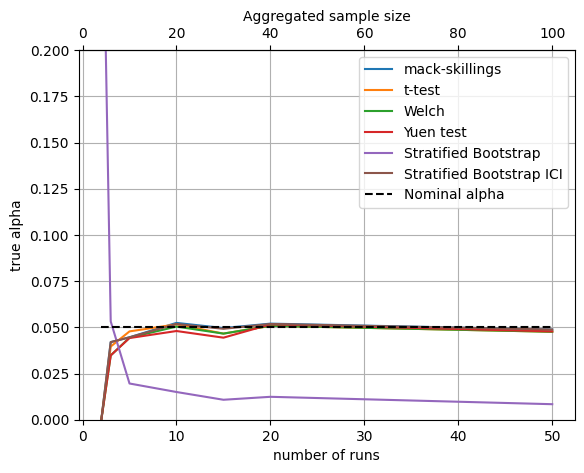

In [11]:
# Two policies and 5 tasks. Tasks of the two reference policies have the same mean and variance but are not normal distribution.

# fpos_MS, fpos_t, fpos_welch, fpos_welch_trim = run_simulation(nominal_alpha=0.05, TASK_DISTR = list([["norm", "norm", "loggamma", "t", "beta"], ["norm", "norm", "loggamma", "t", "beta"]]))

fpos_MS, fpos_t, fpos_welch, fpos_welch_trim, fpos_SB, fpos_SBo = run_simulation(nominal_alpha=nominal_alpha, N=N, K=K, Nsim = Nsim, TASK_MEAN=list([[0, 0], [0, 0]]), TASK_VAR=list([[1, 1], [1, 1]]),  TASK_DISTR=list([["lognorm", "t"], ["lognorm", "t"]]))

run_to_sample = lambda x : x *K
sample_to_run = lambda x : x /K

fig, ax = plt.subplots()
ax.plot(Cs, fpos_MS, label='mack-skillings')
ax.plot(Cs, fpos_t, label='t-test')
ax.plot(Cs, fpos_welch, label='Welch')
ax.plot(Cs, fpos_welch_trim, label='Yuen test')
ax.plot(Cs, fpos_SB, label='Stratified Bootstrap')
ax.plot(Cs, fpos_SBo, label='Stratified Bootstrap ICI')
ax.plot(Cs, nominal_alpha*np.ones(len(Cs)), 'k--', label='Nominal alpha')
ax.legend()
ax.grid()
ax.set_xlabel('number of runs')
ax.set_ylabel('true alpha')
ax.set_ylim([0, 0.2])
secax = ax.secondary_xaxis('top', functions=(run_to_sample, sample_to_run))
secax.set_xlabel('Aggregated sample size')


In [12]:
N=5
K = 2
nominal_alpha = 0.05

# TODO second axis scaled by N, not K!

Text(0.5, 0, 'Aggregated sample size')

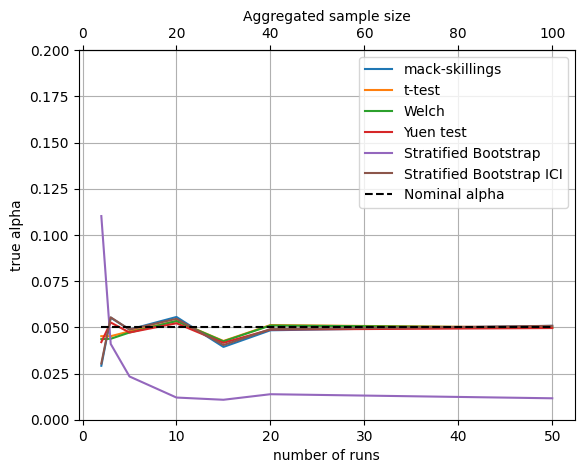

In [13]:
# Five tasks of the two reference policies have the distribution, same mean and variance. Distributions are not normal.

fpos_MS, fpos_t, fpos_welch, fpos_welch_trim, fpos_SB, fpos_SBo = run_simulation(nominal_alpha=nominal_alpha, N=N, K=K, Nsim = Nsim, TASK_DISTR = list([["norm", "norm", "lognorm", "t", "beta"], ["norm", "norm", "lognorm", "t", "beta"]]))

run_to_sample = lambda x : x *K
sample_to_run = lambda x : x /K


fig, ax = plt.subplots()
ax.plot(Cs, fpos_MS, label='mack-skillings')
ax.plot(Cs, fpos_t, label='t-test')
ax.plot(Cs, fpos_welch, label='Welch')
ax.plot(Cs, fpos_welch_trim, label='Yuen test')
ax.plot(Cs, fpos_SB, label='Stratified Bootstrap')
ax.plot(Cs, fpos_SBo, label='Stratified Bootstrap ICI')
ax.plot(Cs, nominal_alpha*np.ones(len(Cs)), 'k--', label='Nominal alpha')
ax.legend()
ax.grid()
ax.set_xlabel('number of runs')
ax.set_ylabel('true alpha')
ax.set_ylim([0, 0.2])
secax = ax.secondary_xaxis('top', functions=(run_to_sample, sample_to_run))
secax.set_xlabel('Aggregated sample size')

Text(0.5, 0, 'Aggregated sample size')

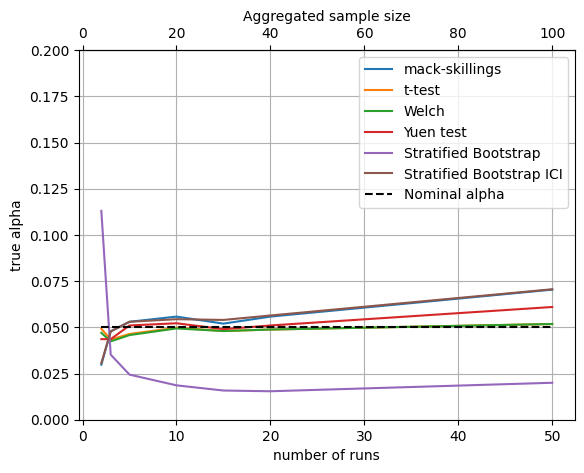

In [14]:
# Changing distribution between two policies

fpos_MS, fpos_t, fpos_welch, fpos_welch_trim, fpos_SB, fpos_SBo = run_simulation(nominal_alpha=nominal_alpha, N=N, K=K, Nsim = Nsim, TASK_DISTR = list([["norm", "norm", "lognorm", "t", "beta"], ["gamma", "lognorm", "dweibull", "t", "beta"]]))

run_to_sample = lambda x : x *K
sample_to_run = lambda x : x /K

fig, ax = plt.subplots()
ax.plot(Cs, fpos_MS, label='mack-skillings')
ax.plot(Cs, fpos_t, label='t-test')
ax.plot(Cs, fpos_welch, label='Welch')
ax.plot(Cs, fpos_welch_trim, label='Yuen test')
ax.plot(Cs, fpos_SB, label='Stratified Bootstrap')
ax.plot(Cs, fpos_SBo, label='Stratified Bootstrap ICI')
ax.plot(Cs, nominal_alpha*np.ones(len(Cs)), 'k--', label='Nominal alpha')
ax.legend()
ax.grid()
ax.set_xlabel('number of runs')
ax.set_ylabel('true alpha')
ax.set_ylim([0, 0.2])
secax = ax.secondary_xaxis('top', functions=(run_to_sample, sample_to_run))
secax.set_xlabel('Aggregated sample size')


Text(0.5, 0, 'Aggregated sample size')

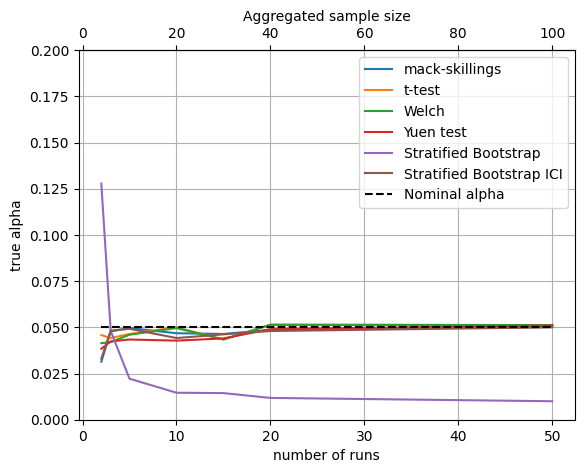

In [15]:
# Tasks of the two reference policies have the distribution and same mean. Distributions are not normal and the variances change from task to task.

fpos_MS, fpos_t, fpos_welch, fpos_welch_trim, fpos_SB, fpos_SBo = run_simulation(nominal_alpha=nominal_alpha, N=N, K=K, Nsim = Nsim, TASK_VAR=list([[1, 2, 10, 0.1, 8], [1, 2, 10, 0.1, 8]]), TASK_DISTR = list([["norm", "norm", "lognorm", "t", "beta"], ["norm", "norm", "lognorm", "t", "beta"]]))

run_to_sample = lambda x : x *K
sample_to_run = lambda x : x /K

fig, ax = plt.subplots()
ax.plot(Cs, fpos_MS, label='mack-skillings')
ax.plot(Cs, fpos_t, label='t-test')
ax.plot(Cs, fpos_welch, label='Welch')
ax.plot(Cs, fpos_welch_trim, label='Yuen test')
ax.plot(Cs, fpos_SB, label='Stratified Bootstrap')
ax.plot(Cs, fpos_SBo, label='Stratified Bootstrap ICI')
ax.plot(Cs, nominal_alpha*np.ones(len(Cs)), 'k--', label='Nominal alpha')
ax.legend()
ax.grid()
ax.set_xlabel('number of runs')
ax.set_ylabel('true alpha')
ax.set_ylim([0, 0.2])
secax = ax.secondary_xaxis('top', functions=(run_to_sample, sample_to_run))
secax.set_xlabel('Aggregated sample size')

Text(0.5, 0, 'Aggregated sample size')

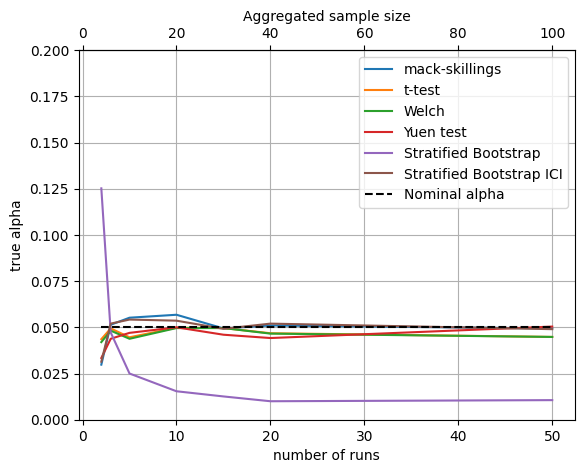

In [16]:
# Tasks of the two reference policies have the distribution type and same mean. Distributions are not normal and the variances change from task to task and also within the same task from one policy to the other.

fpos_MS, fpos_t, fpos_welch, fpos_welch_trim, fpos_SB, fpos_SBo = run_simulation(nominal_alpha=nominal_alpha, N=N, K=K, Nsim = Nsim, TASK_VAR=list([[1, 2, 10, 0.1, 8], [1, 4, 12, 0.5, 6]]), TASK_DISTR = list([["norm", "norm", "lognorm", "t", "beta"], ["norm", "norm", "lognorm", "t", "beta"]]))

run_to_sample = lambda x : x *K
sample_to_run = lambda x : x /K

fig, ax = plt.subplots()
ax.plot(Cs, fpos_MS, label='mack-skillings')
ax.plot(Cs, fpos_t, label='t-test')
ax.plot(Cs, fpos_welch, label='Welch')
ax.plot(Cs, fpos_welch_trim, label='Yuen test')
ax.plot(Cs, fpos_SB, label='Stratified Bootstrap')
ax.plot(Cs, fpos_SBo, label='Stratified Bootstrap ICI')
ax.plot(Cs, nominal_alpha*np.ones(len(Cs)), 'k--', label='Nominal alpha')
ax.legend()
ax.grid()
ax.set_xlabel('number of runs')
ax.set_ylabel('true alpha')
ax.set_ylim([0, 0.2])
secax = ax.secondary_xaxis('top', functions=(run_to_sample, sample_to_run))
secax.set_xlabel('Aggregated sample size')

Text(0.5, 0, 'Aggregated sample size')

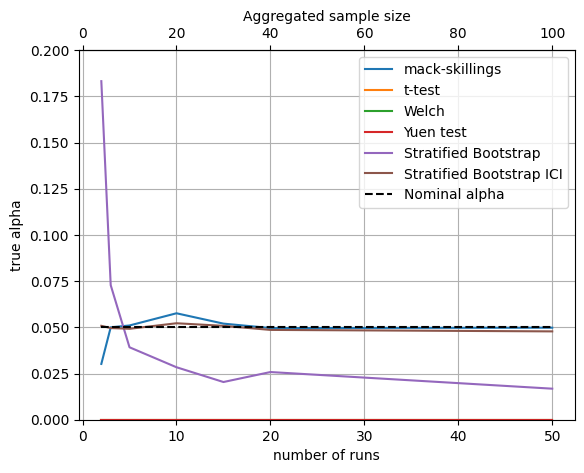

In [17]:
# Tasks of the two reference policies have the distribution type and same mean. Distributions are not normal and the variances change from task to task and also within the same task from one policy to the other.

fpos_MS, fpos_t, fpos_welch, fpos_welch_trim, fpos_SB, fpos_SBo = run_simulation(nominal_alpha=nominal_alpha, N=N, K=K, Nsim = Nsim, TASK_MEAN=list([[0, -1, 0.001, 10, 100], [0, -1, 0.001, 10, 100]]), TASK_VAR=list([[1, 2, 10, 0.1, 8], [1, 4, 12, 0.5, 6]]), TASK_DISTR = list([["norm", "norm", "lognorm", "t", "beta"], ["norm", "norm", "lognorm", "t", "beta"]]))

run_to_sample = lambda x : x *K
sample_to_run = lambda x : x /K

fig, ax = plt.subplots()
ax.plot(Cs, fpos_MS, label='mack-skillings')
ax.plot(Cs, fpos_t, label='t-test')
ax.plot(Cs, fpos_welch, label='Welch')
ax.plot(Cs, fpos_welch_trim, label='Yuen test')
ax.plot(Cs, fpos_SB, label='Stratified Bootstrap')
ax.plot(Cs, fpos_SBo, label='Stratified Bootstrap ICI')
ax.plot(Cs, nominal_alpha*np.ones(len(Cs)), 'k--', label='Nominal alpha')
ax.legend()
ax.grid()
ax.set_xlabel('number of runs')
ax.set_ylabel('true alpha')
ax.set_ylim([0, 0.2])
secax = ax.secondary_xaxis('top', functions=(run_to_sample, sample_to_run))
secax.set_xlabel('Aggregated sample size')

# Statistical power

In [18]:
N=2
K = 2
Nsim=1000
nominal_alpha = 0.05

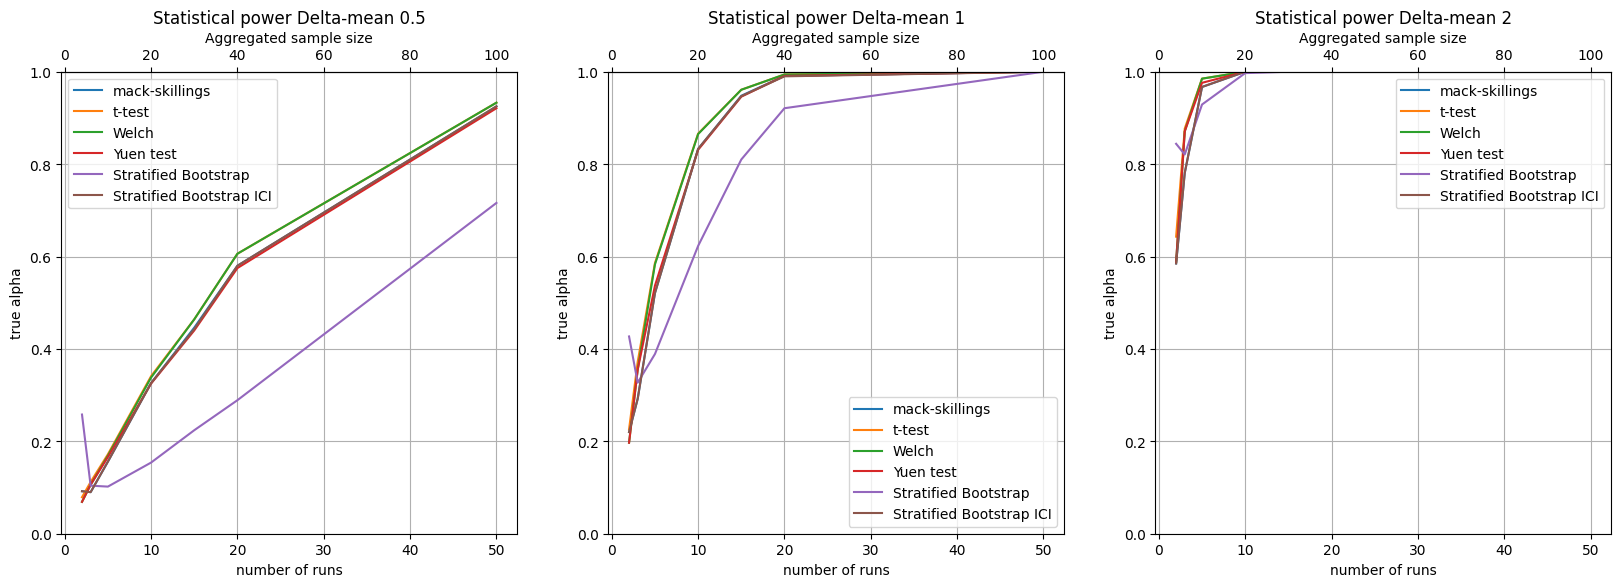

In [19]:
# Two policies and 2 tasks. All distributions have normal distribution. Same variance. Same means. Small effect size is applied

epslist = list([0.5, 1, 2])
fig, ax = plt.subplots(1,3, figsize = (20, 6))
for eps, i in zip(epslist, range(len(epslist))):

    fpos_MS, fpos_t, fpos_welch, fpos_welch_trim, fpos_SB, fpos_SBo = run_simulation(nominal_alpha=nominal_alpha, N=N, K=K, Nsim = Nsim, TASK_MEAN=list([[0, 0], [eps, eps]]), TASK_VAR=list([[1, 1], [1, 1]]),  TASK_DISTR=list([["norm", "norm"], ["norm", "norm"]]))
    # fpos_MS, fpos_t, fpos_welch, fpos_welch_trim = run_simulation(nominal_alpha=0.05, TASK_MEAN=list([[0, -1, 0.001, 10, 100], [0, -1, 0.001, 10, 100]]))

    run_to_sample = lambda x : x *K
    sample_to_run = lambda x : x /K

    ax[i].plot(Cs, fpos_MS, label='mack-skillings')
    ax[i].plot(Cs, fpos_t, label='t-test')
    ax[i].plot(Cs, fpos_welch, label='Welch')
    ax[i].plot(Cs, fpos_welch_trim, label='Yuen test')
    ax[i].plot(Cs, fpos_SB, label='Stratified Bootstrap')
    ax[i].plot(Cs, fpos_SBo, label='Stratified Bootstrap ICI')
    ax[i].legend()
    ax[i].grid()
    ax[i].set_xlabel('number of runs')
    ax[i].set_ylabel('true alpha')
    ax[i].set_ylim([0, 1])
    secax = ax[i].secondary_xaxis('top', functions=(run_to_sample, sample_to_run))
    secax.set_xlabel('Aggregated sample size')
    ax[i].set_title(f'Statistical power Delta-mean {eps}')

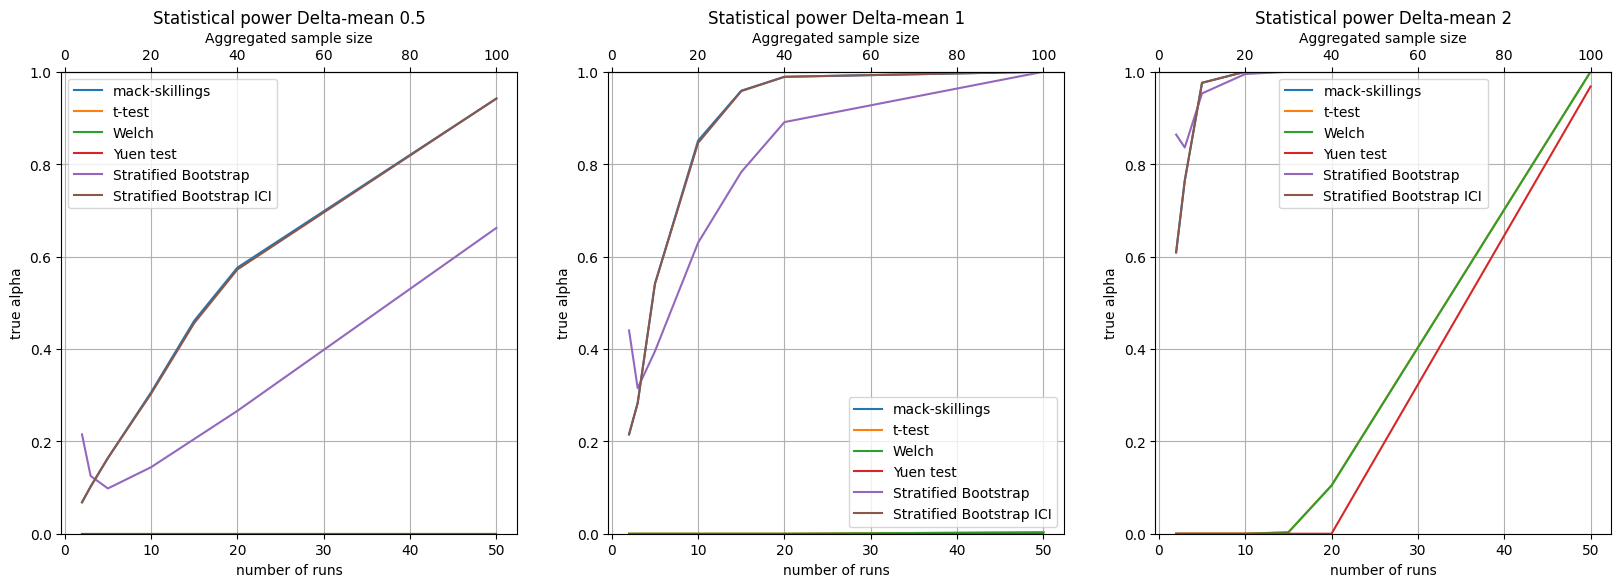

In [20]:
# Two policies and 2 tasks. All distributions have normal distribution. Same variance. Different Means + effect size is applied

epslist = list([0.5, 1, 2])
fig, ax = plt.subplots(1,3, figsize = (20, 6))
for eps, i in zip(epslist, range(len(epslist))):

    fpos_MS, fpos_t, fpos_welch, fpos_welch_trim, fpos_SB, fpos_SBo = run_simulation(nominal_alpha=nominal_alpha, N=N, K=K, Nsim = Nsim, TASK_MEAN=list([[0.001, 10], [0.001 + eps, 10 + eps]]), TASK_VAR=list([[1, 1], [1, 1]]),  TASK_DISTR=list([["norm", "norm"], ["norm", "norm"]]))
    # fpos_MS, fpos_t, fpos_welch, fpos_welch_trim = run_simulation(nominal_alpha=0.05, TASK_MEAN=list([[0, -1, 0.001, 10, 100], [0, -1, 0.001, 10, 100]]))

    run_to_sample = lambda x : x *K
    sample_to_run = lambda x : x /K

    ax[i].plot(Cs, fpos_MS, label='mack-skillings')
    ax[i].plot(Cs, fpos_t, label='t-test')
    ax[i].plot(Cs, fpos_welch, label='Welch')
    ax[i].plot(Cs, fpos_welch_trim, label='Yuen test')
    ax[i].plot(Cs, fpos_SB, label='Stratified Bootstrap')
    ax[i].plot(Cs, fpos_SBo, label='Stratified Bootstrap ICI')
    ax[i].legend()
    ax[i].grid()
    ax[i].set_xlabel('number of runs')
    ax[i].set_ylabel('true alpha')
    ax[i].set_ylim([0, 1])
    secax = ax[i].secondary_xaxis('top', functions=(run_to_sample, sample_to_run))
    secax.set_xlabel('Aggregated sample size')
    ax[i].set_title(f'Statistical power Delta-mean {eps}')